In [1]:
""""
The goal of this homework is to understand the approaches for taking derivatives and I will provide derivatives to the optimizer. I will use the truss problem with code available here: https://github.com/mdobook/resources/tree/main/exercises/tenbartruss

I will use the following methods:
    - Forward Finite Difference
    - Complex-Step Derivative
    - Algorithmic Differenctiation
"""
import numpy as np
from truss import truss # For finite difference and complex step

import jax.numpy as jnp
from jax import jacfwd
from truss_jax import truss_jax # For automatic differentiation

from scipy.optimize import minimize, NonlinearConstraint
import matplotlib.pyplot as plt

In [2]:
"""
Foward finite-difference Gradient Compuation of a Vector-Valued Function
    inputs:
        - x: point about which to compute the gradients
        - h: step size to use when calculating the gradient, defaults to 1e-6
        - mode: what kind of derivative (either of the mass or stresses wrt the cross sectional area)
    outputs:
        - J: jacobian of f wrt x
"""

def ff_jacobians(x, h=1e-6, mode='mass'):
    mass0, stress0 = truss(x)

    J_mass = np.zeros((len(x),))
    J_stress = np.zeros((len(x), len(x)))

    for j in range(len(x)):
        x[j] += h
        mass_forward, stress_forward = truss(x)
        J_mass[j] = (mass_forward - mass0) / h
        J_stress[:,j] = (stress_forward - stress0) / h
        x[j] -= h

    if mode == 'mass':
        return J_mass
    else:
        return J_stress

In [3]:
"""
Complex Step Gradient Compuation of a Vector-Valued Function
    inputs:
        - x: point about which to compute the gradients
        - h: step size to use when calculating the gradient, defaults to 1e-6
        - mode: what kind of derivative (either of the mass or stresses wrt the cross sectional area)
    outputs:
        - J: jacobian of f wrt x
"""

def complex_jacobians(x, h=1e-20, mode='mass'):
    J_mass = np.zeros((len(x),))
    J_stress = np.zeros((len(x), len(x)))

    x = x.astype('complex')

    for j in range(len(x)):
        x[j] += complex(0, h)
        mass_forward, stress_forward = truss(x)
        J_mass[j] = mass_forward.imag / h
        J_stress[:,j] = stress_forward.imag / h
        x[j] -= complex(0, h)

    if mode == 'mass':
        return J_mass
    else:
        return J_stress

In [4]:
"""
Forward Mode Automatic Differentiaton
    inputs:
        - x: point about which to compute the gradients
        - mode: what kind of derivative (either of the mass or stresses wrt the cross sectional area)
    outputs:
        - J: jacobian of f wrt x
"""

def ad_jacobians(x, fun, mode='mass'):
    if mode =='mass':
        return fun(x, get_mass=True)
    return fun(x) # Return stress jacobian


In [5]:
# CONSTRAINTS
YIELD_STRESS = np.ones(10,)*25e3 # psi
YIELD_STRESS[8] = 75e3 # psi for member 9 only
MIN_CROSS_SECTION = 0.1 # in^2, bound constraint
CROSS_SECTION_BOUNDS = (MIN_CROSS_SECTION, np.inf)

ad_jacob = jacfwd(truss_jax)


# Constraint
def g(x):
    _, stress = truss(x)
    return stress

def dg_ad(x):
    return ad_jacobians(x, ad_jacob, mode='stress')
def dg_complex(x):
    return complex_jacobians(x, mode='stress')

# Objective Function
def f(x):
    mass, _ = truss(x)
    return mass

def df(x, method='ad'):
    if method == 'ad':
        return ad_jacobians(x, ad_jacob, mode='mass')
    else:
        return complex_jacobians(x, mode='mass')

def obj_ad(x):
    return f(x), df(x, method='ad')
def obj_complex(x):
    return f(x), df(x, method='complex')

In [6]:
# Test Part 1 with Values given
A0 = np.ones((10,))*3.0

# Test Mass Jacobians
print("Finite Difference Steps:")
print(ff_jacobians(A0, h=1e-8, mode='mass'))
print(ff_jacobians(A0, h=1e-13, mode='mass'))
print(ff_jacobians(A0, h=1e-16, mode='mass'))
print()
print(f"Complex Step: {df(A0, method='complex')}")
print()
print(f"Automatic Differentiation: {df(A0)}")

Finite Difference Steps:
[35.99998308 35.99998308 35.99998308 35.99998308 35.99998308 35.99998308
 50.91167168 50.91167168 50.91167168 50.91167168]
[34.10605132 34.10605132 34.10605132 34.10605132 36.37978807 36.37978807
 50.0222086  50.0222086  50.0222086  50.0222086 ]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]

Complex Step: [36.         36.         36.         36.         36.         36.
 50.91168825 50.91168825 50.91168825 50.91168825]

Automatic Differentiation: [36.      36.      36.      36.      36.      36.      50.91169 50.91169
 50.91169 50.91169]


In [8]:
# Test Stress Jacobians
print("Finite Difference Steps:")
print(ff_jacobians(A0, h=1e-4, mode='stress')[0, :])
print(ff_jacobians(A0, h=1e-8, mode='stress')[0, :])
print(ff_jacobians(A0, h=1e-12, mode='stress')[0, :])
print(ff_jacobians(A0, h=1e-13, mode='stress')[0, :])
print(ff_jacobians(A0, h=1e-15, mode='stress')[0, :])
print(ff_jacobians(A0, h=1e-16, mode='stress')[0, :])


# Test Complex Step
print("Complex Step:")
print(dg_complex(A0)[0, :])

print("AD:")
print(dg_ad(A0)[0,:])

Finite Difference Steps:
[-19168.78007396    -53.97419598  -2658.21988098     80.54216538
    413.27381914    -53.97419707  -3844.46648415   3503.8701247
    227.80909952   -152.66305149]
[-19169.3448869     -53.96432243  -2658.29803539     80.54703358
    413.28166844    -54.00142982  -3844.55197491   3503.94402631
    227.81532607   -152.67141862]
[-19179.42427099    -72.75957614  -2663.00048679     87.31149137
    422.00554162    -94.58744898  -3834.42966267   3463.35582435
    138.24319467   -211.00277081]
[-19499.56640601    509.31703299  -2328.30643654    145.51915228
    363.79788071  -1964.50855583  -3565.21923095   3856.25753552
    363.79788071  -1091.39364213]
[ -87311.4913702    14551.91522837   36379.78807092   65483.61852765
       0.         -138243.19466949  -14551.91522837       0.
   65483.61852765 -138243.19466949]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Complex Step:
[-19169.3443296     -53.9758053   -2658.29812902     80.54456851
    413.28487417    -53.9758053   -3844.552

In [10]:
A0 = np.ones((10,))*2.0

ff_stress = ff_jacobians(A0, h=1e-10, mode='stress')
complex_stress = dg_complex(A0)
ad_stress = dg_ad(A0)

print(f'Finite Differencing Error: {np.mean(np.divide(ad_stress - ff_stress, ff_stress))}')
print(f'Complex Step Error: {np.mean(np.divide(ad_stress - complex_stress, complex_stress))}')

Finite Differencing Error: -6.033143488355694e-06
Complex Step Error: 1.0172006711893826e-06


     fun: 1497.6000000036158
     jac: array([36.        , 36.        , 36.        , 36.        , 36.        ,
       36.        , 50.91168976, 50.91168976, 50.91168976, 50.91168976])
 message: 'Optimization terminated successfully'
    nfev: 1
     nit: 1
    njev: 1
  status: 0
 success: True
       x: array([7.9       , 0.1       , 8.1       , 3.9       , 0.1       ,
       0.1       , 5.79827561, 5.51543289, 3.67695526, 0.14142136])


Text(0, 0.5, 'Norm of the Change in x values')

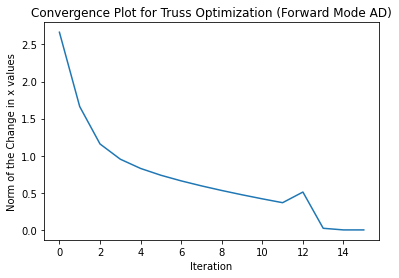

In [14]:
# Get Results for AD

x0 = np.ones(10,)*2.0 # Initial Guess for Cross Sectional Area of each member

_constraints = NonlinearConstraint(g, -YIELD_STRESS, YIELD_STRESS, jac=dg_ad)
_bounds = tuple([CROSS_SECTION_BOUNDS for b in range(10)])

theoptions = {'disp': False, 'maxiter': 2}
convergence = [100]
prevX = x0

while convergence[-1] > 1e-6:
    res = minimize(obj_ad, x0, constraints=_constraints, bounds=_bounds, tol=1e-6, jac=True, options=theoptions)
    prevX = x0
    x0 = res.x
    convergence.append(np.linalg.norm(x0-prevX))

convergence = convergence[1:]
print(res)

plt.plot(convergence)
plt.title("Convergence Plot for Truss Optimization (Forward Mode AD)")
plt.xlabel("Iteration")
plt.ylabel("Norm of the Change in x values")
# Optimization result wih my gradients: [7.9, 0.1, 8.1, 3.9, 0.1,  0.1,  5.79828, 5.51543, 3.67696, 0.14142]

     fun: 1497.6000000459785
     jac: array([36.        , 36.        , 36.        , 36.        , 36.        ,
       36.        , 50.91168825, 50.91168825, 50.91168825, 50.91168825])
 message: 'Optimization terminated successfully'
    nfev: 2
     nit: 1
    njev: 1
  status: 0
 success: True
       x: array([7.9       , 0.1       , 8.1       , 3.9       , 0.1       ,
       0.1       , 5.79827561, 5.51543289, 3.67695526, 0.14142136])


Text(0, 0.5, 'Norm of the Change in x values')

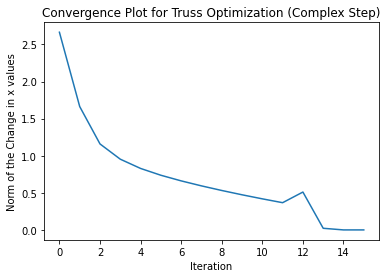

In [15]:
# Get Results for Complex Step

x0 = np.ones(10,)*2.0 # Initial Guess for Cross Sectional Area of each member

_constraints = NonlinearConstraint(g, -YIELD_STRESS, YIELD_STRESS, jac=dg_complex)
_bounds = tuple([CROSS_SECTION_BOUNDS for b in range(10)])

theoptions = {'disp': False, 'maxiter': 2}
convergence = [100]
prevX = x0

while convergence[-1] > 1e-6:
    res = minimize(obj_complex, x0, constraints=_constraints, bounds=_bounds, tol=1e-6, jac=True, options=theoptions)
    prevX = x0
    x0 = res.x
    convergence.append(np.linalg.norm(x0-prevX))

convergence = convergence[1:]
print(res)

plt.plot(convergence)
plt.title("Convergence Plot for Truss Optimization (Complex Step)")
plt.xlabel("Iteration")
plt.ylabel("Norm of the Change in x values")
# Optimization result wih my gradients: [7.9, 0.1, 8.1, 3.9, 0.1,  0.1,  5.79828, 5.51543, 3.67696, 0.14142]

In [18]:
# AD Optimization
x0 = np.ones((10,))*2.0
_constraints = NonlinearConstraint(g, -YIELD_STRESS, YIELD_STRESS, jac=dg_ad)
_bounds = tuple([CROSS_SECTION_BOUNDS for b in range(10)])

res = minimize(obj_ad, x0, constraints=_constraints, bounds=_bounds, tol=1e-6, jac=True)
print(res)

c:\Users\danie\anaconda3\envs\pyt37\lib\site-packages\scipy\optimize\optimize.py:283: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  "minimize step, clipping to bounds", RuntimeWarning)


     fun: 1497.5999999892817
     jac: array([36.        , 36.        , 36.        , 36.        , 36.        ,
       36.        , 50.91168976, 50.91168976, 50.91168976, 50.91168976])
 message: 'Optimization terminated successfully'
    nfev: 67
     nit: 20
    njev: 16
  status: 0
 success: True
       x: array([7.9       , 0.1       , 8.1       , 3.9       , 0.1       ,
       0.1       , 5.79827561, 5.51543289, 3.67695526, 0.14142136])


In [19]:
# Complex Optimization
x0 = np.ones((10,))*2.0
_constraints = NonlinearConstraint(g, -YIELD_STRESS, YIELD_STRESS, jac=dg_complex)
_bounds = tuple([CROSS_SECTION_BOUNDS for b in range(10)])

res = minimize(obj_complex, x0, constraints=_constraints, bounds=_bounds, tol=1e-6, jac=True)
print(res)

     fun: 1497.6000000436209
     jac: array([36.        , 36.        , 36.        , 36.        , 36.        ,
       36.        , 50.91168825, 50.91168825, 50.91168825, 50.91168825])
 message: 'Optimization terminated successfully'
    nfev: 12
     nit: 10
    njev: 9
  status: 0
 success: True
       x: array([7.9       , 0.1       , 8.1       , 3.9       , 0.1       ,
       0.1       , 5.79827561, 5.51543289, 3.67695526, 0.14142136])


In [17]:
x0 = np.ones(10,)*2.0 # Initial Guess for Cross Sectional Area of each member
_constraints = NonlinearConstraint(g, -YIELD_STRESS, YIELD_STRESS)

res_nograd = minimize(f, x0, constraints=_constraints, bounds=_bounds, tol=1e-6, jac=False)
print(res_nograd)

     fun: 1497.5999999906949
     jac: array([36.        , 36.        , 36.        , 36.        , 36.        ,
       36.        , 50.91168213, 50.91168213, 50.91169739, 50.91169739])
 message: 'Optimization terminated successfully'
    nfev: 153
     nit: 16
    njev: 12
  status: 0
 success: True
       x: array([7.9       , 0.1       , 8.1       , 3.9       , 0.1       ,
       0.1       , 5.79827561, 5.51543289, 3.67695526, 0.14142136])
